In [1]:
%matplotlib inline

import array as arr
import binascii
import colorama
import itertools
import math
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
#import statistics as s
import sys
###import tkinter as tk

from colorama import Fore, Back, Style
from datetime import datetime, time, timedelta
from itertools import count # izip for maximum efficiency
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.signal import tukey
from scipy.stats import norm,rayleigh,skew,kurtosis
from statistics import mean
from tkinter import filedialog
from tkinter import *
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


In [2]:
def get_file():

# Select input file - code from https://pythonspot.com/tk-file-dialogs/
    root = Tk() 
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data",\
    title = "Select .ASCII file",filetypes = (("CSV files","*.csv"),("all files","*.*")))
                                                
    root.destroy()

    return(root.filename)

In [215]:
import math

def percentile(data, percentile):
    size = len(data)
    return sorted(data)[int(math.ceil((size * percentile) / 100)) - 1]

def do_stats(df):
    p50 = percentile(df.Hsrms, 50)
    p90 = percentile(df.Hsrms, 90)
    p95 = percentile(df.Hsrms, 95)
    p99 = percentile(df.Hsrms, 99)

    print('{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}'.\
              format(mean(df.Hsrms),np.median(df.Hsrms),p90,p95,p99,max(df.Hsrms)))
    return(mean(df.Hsrms),np.median(df.Hsrms),p90,p95,p99,max(df.Hsrms))


In [50]:
def do_calcs(df,max_val,total_time):
    
    print('{:>9s}'.format(""), end=" ")
    for item in range(6,78,6): print('{:>6d}'.format(item), end=" ")
    print() 
    
    level = 0.25    # set initial height level
    
# Create table to hold individual values from calc's
    table = pd.DataFrame(columns=['Hs','6','12','18','24','30','36','42','48','54','60','66','72'])

    while level < max_val:
        pd.set_option('mode.chained_assignment',None)
        found = df.loc[df.Hsrms >= level].copy()
        found['Diff'] = found.index.to_series().diff().dt.total_seconds().div(3600, fill_value=0)
        level_time = sum(found.loc[found.Diff>0.5].Diff)
        Duration_band = []; Row = []
        remainder = sum(found.loc[found.Diff <= 6].Diff)/24
    #    print('Remainder = ',remainder)
        Row.append(level)

        for step in range(6,78,6):
            bin_vals = sum(found.loc[found.Diff > step].Diff)/24
    #        remainder = sum(found.loc[found.Diff <= 6].Diff)/24
            Duration_band.append(bin_vals/(total_time)*100) # get % of total hours for each time band
            Row.append(bin_vals)

        numEl = len(Row)
        newRow = pd.DataFrame(np.array(Row).reshape(1,numEl), columns = list(table.columns))
        table = table.append(newRow, ignore_index=True)

        print('{:>2s}{:<7.2f}{:>9.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}'\
              .format('< ',level,*Duration_band))

        level += 0.25

    return(table)

In [ ]:
def insert_breaks(x,y):
    import datetime as dtm
    import numpy    as np

    xnew = []
    ynew = []
    for dt1, dt0, y1, y0 in zip(x[1:],x[:-1],y[1:],y[:-1]):
        if dt1-dt0 <= dtm.timedelta(hours=0.5):
            xnew+=[dt0]
            ynew+=[y0]
        else:
            xnew+=[dt0,dt0+(dt1-dt0)/2]
            ynew+=[y0, np.nan]

    xnew+=[dt1]
    ynew+=[y1]

    return xnew, ynew

In [148]:
def do_plot(df,plot_title):

    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.set_title(plot_title,fontsize=12)
    ax.grid(True)
    ax.set_ylim([0,max(df.Hsrms)])
#    ax.set_major_formatter(df.index.DateFormatter("%d"))
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms<=0.25)].index,df.loc[(df.Hsrms<=0.25)].Hsrms); ax.plot(x,y,'r')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=0.25)].index,df.loc[(df.Hsrms>=0.25)].Hsrms); ax.plot(x,y,'orange')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=0.5)].index,df.loc[(df.Hsrms>=0.5)].Hsrms); ax.plot(x,y,'yellow')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=0.75)].index,df.loc[(df.Hsrms>=0.75)].Hsrms); ax.plot(x,y,'g')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=1)].index,df.loc[(df.Hsrms>=1)].Hsrms); ax.plot(x,y,'b')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=2)].index,df.loc[(df.Hsrms>=2)].Hsrms); ax.plot(x,y,'indigo')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=3)].index,df.loc[(df.Hsrms>=3)].Hsrms); ax.plot(x,y,'cyan')
    except:
        pass
    plt.show()
    return()

Total number of days available =   175.23 days.
Number of days without gaps =  175.23 
All data
               6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        9.26   3.90   1.88   1.45   0.86   0.86   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       65.13  64.13  61.85  58.00  56.06  56.06  54.24  52.07  52.07  52.07  49.03  47.41
< 0.75       80.00  79.85  79.53  79.53  79.53  79.53  79.53  79.53  79.53  79.53  79.53  79.53
< 1.00       83.68  83.68  83.68  83.21  83.21  83.21  82.36  82.36  82.36  82.36  82.36  82.36
< 1.25       87.33  87.09  86.71  86.18  86.18  86.18  86.18  86.18  86.18  86.18  86.18  86.18
< 1.50       88.38  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94
< 1.75       90.44  90.22  89.83  89.39  88.80  88.80  88.80  88.80  88.80  88.80  88.80  88.80
< 2.00       92.27  92.11  92.11  92.11  91.48  91.48  91.48  91.48  91.48  91.48  91.48  91.48
< 2.25       94.28  94.06  93.69  93.19  


January
               6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25       10.63   4.95   2.92   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       39.45  38.15  32.95  32.95  28.17  28.17  28.17  28.17  28.17  28.17  28.17  28.17
< 0.75       64.12  64.12  61.93  61.93  61.93  61.93  61.93  61.93  61.93  61.93  61.93  61.93
< 1.00       67.78  67.78  67.78  64.61  64.61  64.61  64.61  64.61  64.61  64.61  64.61  64.61
< 1.25       71.35  71.35  68.75  68.75  68.75  68.75  68.75  68.75  68.75  68.75  68.75  68.75
< 1.50       72.97  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51
< 1.75       82.71  81.17  78.57  75.57  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51
< 2.00       89.61  89.61  89.61  89.61  85.31  85.31  85.31  85.31  85.31  85.31  85.31  85.31
< 2.25       93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34
< 2.50       98.05  95.37  95.37


February
               6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        4.10   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36
< 0.75       37.75  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78
< 1.00       47.80  47.80  47.80  47.80  47.80  47.80  42.44  42.44  42.44  42.44  42.44  42.44
< 1.25       62.62  61.13  61.13  57.86  57.86  57.86  57.86  57.86  57.86  57.86  57.86  57.86
< 1.50       66.05  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63
< 1.75       67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46
< 2.00       69.55  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50
< 2.25       75.73  74.31  72.00  68.88  68.88  68.88  68.88  68.88  68.88  68.88  68.88  68.88
< 2.50       87.64  83.92  79.6

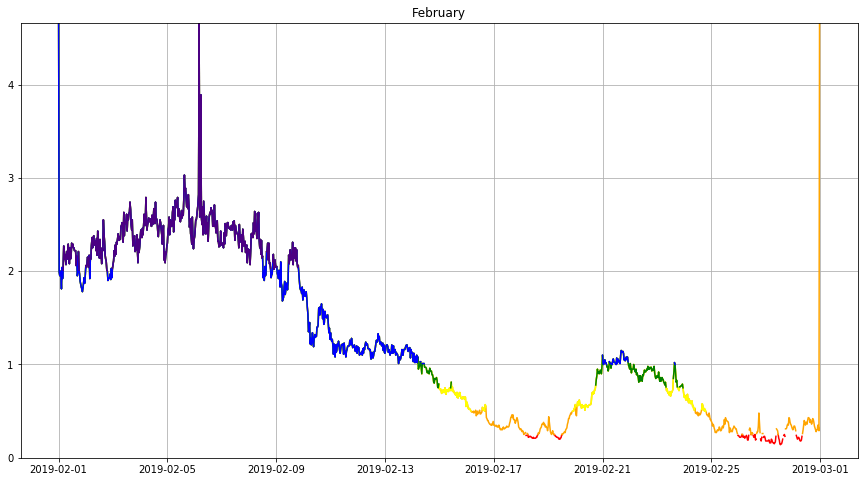


March
               6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25       21.59  14.12   8.20   8.20   4.84   4.84   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       58.71  58.71  58.71  58.71  55.14  55.14  50.30  50.30  50.30  50.30  50.30  50.30
< 0.75       74.18  74.18  74.18  74.18  74.18  74.18  74.18  74.18  67.65  67.65  67.65  67.65
< 1.00       81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  72.16
< 1.25       85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88
< 1.50       87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42
< 1.75       89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71
< 2.00       92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47
< 2.25       94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49
< 2.50       96.77  96.77  96.77  


April
               6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25       10.42   3.96   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       97.98  97.98  95.90  95.90  88.67  84.43  84.43  78.46  78.46  78.46  78.46  78.46



May
               6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        5.51   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       86.42  84.53  82.31  71.69  71.69  67.18  67.18  60.73  60.73  60.73  60.73  51.58
< 0.75       98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72


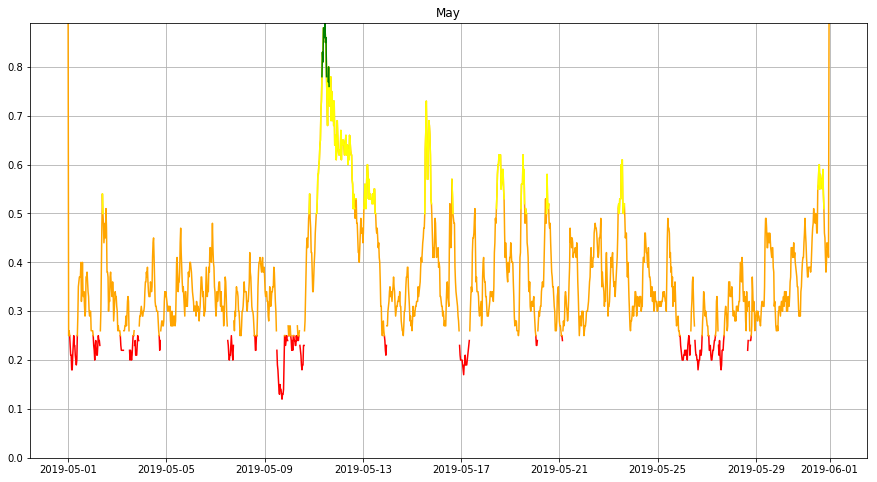


June
               6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        2.82   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       74.47  70.31  67.84  56.14  56.14  56.14  50.42  50.42  50.42  50.42  41.47  41.47


 Period     Mean  Median   P90    P95    P99    Max
All data    0.41   0.39   0.60   0.64   0.70   0.75
 January    0.87   0.58   1.93   2.27   2.56   4.10
February    1.21   1.01   2.47   2.56   2.74   4.66
   March    0.66   0.38   1.69   2.25   2.57   2.85
   April    0.30   0.29   0.41   0.45   0.53   0.58
     May    0.36   0.33   0.52   0.61   0.75   0.89
    June    0.41   0.39   0.60   0.64   0.70   0.75


In [231]:
### Main Program ###

# Get name of input file
Input_ASCII_File = get_file()

# Read data from file into dataframe
df = pd.read_csv(Input_ASCII_File, names=['Date', 'Hsrms', 'Hmax', 'Tz', 'Tp', 'Pk Dir', 'SST'],
            parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M'),
            header=None, sep=',',engine='python')

# Convert Hsrms data fron string values to floats
df['Hsrms'] = pd.to_numeric(df['Hsrms'],errors='coerce')

# set up list of months
months = np.unique(df.Date.dt.month.values).tolist()
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
df.set_index('Date',inplace=True)

# Index the dataframe on dates
df.index = pd.to_datetime(df.index)

# Find time difference (in hours) between consecutive rows in dataframe 
df['Diff'] = df.index.to_series().diff().dt.total_seconds().div(3600, fill_value=0)

# Make a copy of original dataframe for initial plotting purposes
df_2 = df.copy()

# locate the maximum Hsrms value in dataframe
# This will be limit of iteration levels in vertical axis, and limit of gaps in time axis
max_val = float(max(df.Hsrms))

# Set first and last Hsrms values to the maximum 
df.iat[0,0]= max_val; df.iat[len(df)-1,0]= max_val
df.update(df)
level = 0.25

total_time = (df.index[-1:] - df.index[:1]).total_seconds().values[0]/86400
print('Total number of days available = ',end=" ")
print('{:>7.2f}{:6s}'.format(total_time,' days.'))

# Remove gaps from original DF
df_1 = df.loc[df.Diff < 6].copy() # ignore values where gap > 2 hours exist
df_1['Diff'] = df_1.index.to_series().diff().dt.total_seconds().div(3600, fill_value=0)
total_time_df1 = (df_1.index[-1:] - df_1.index[:1]).total_seconds().values[0]/86400
print('Number of days without gaps = ',end=" ")
print('{:<7.2f}'.format(total_time_df1))

# Do calcs and plots for all data
print('All data')
table = do_calcs(df,max_val,total_time)
do_plot(df_2,'All data')

# Do calcs and plots for individual months
for i in months:
    print()
    print(month_names[i-1])
    df1 = df_2.loc[pd.DatetimeIndex(df_2.index).month == i]
    total_time = (df1.index[-1:] - df1.index[:1]).total_seconds().values[0]/86400
    max_val = float(max(df1.Hsrms))
    df1.iat[0,0]= max_val; df1.iat[len(df1)-1,0]= max_val
    do_calcs(df1,max_val,total_time)
    do_plot(df1,month_names[i-1])
    
print('{:<12s}{:<6s}{:>3s}{:>6s}{:>7s}{:>7s}{:>7s}'.format(' Period','Mean','Median','P90','P95','P99','Max'))
print('{:8s}'.format('All data'),end=" ")
do_stats(df1)

for i in months:
    print('{:>8s}'.format(month_names[i-1]),end=" ")
    df1 = df_2.loc[pd.DatetimeIndex(df_2.index).month == i]
    do_stats(df1)

In [232]:
df

Hsrms  Hmax    Tz    Tp  Pk Dir    SST  Diff
Date                                                             
2019-01-06 07:30:00   4.66  0.32  5.17  5.56  320.26  25.94   0.0
2019-01-06 08:00:00   0.75  1.16     5  5.41  310.51  25.94   0.5
2019-01-06 08:30:00   0.84   1.7  5.44  5.56   24.18  26.46   0.5
2019-01-06 09:00:00   0.85  1.35  4.95  7.69  289.41  28.04   0.5
2019-01-06 09:30:00   0.83  1.17  4.91  7.41  288.53  28.58   0.5
2019-01-06 10:00:00   0.79  1.51  4.86  7.69  288.62  28.83   0.5
2019-01-06 10:30:00   0.81  1.53  4.85  7.69  292.31  28.98   0.5
2019-01-06 11:00:00   0.83  1.37  4.82  7.41  290.46  29.22   0.5
2019-01-06 11:30:00   0.80  1.39  4.62  7.41  289.49  29.32   0.5
2019-01-06 12:00:00   0.75  1.15   4.4  7.69  286.86  29.37   0.5
2019-01-06 12:30:00   0.75  1.27  4.42   6.9   290.9  29.62   0.5
2019-01-06 13:00:00   0.81  1.38  4.55  7.69  287.03  29.92   0.5
2019-01-06 13:30:00   0.79  1.29  4.36   6.9  291.43  30.28   0.5
2019-01-06 14:00:00   0.82  1.37  4.15  7.41  288.79  30.28   0.5
2019-01-06 14:30:00   0.81  1.29  3.92  7.41   288.7  30.02   0.5
2019-01-06 15:00:00   0.81  1.34  3.76  7.41  288.18  30.13   0.5
2019-01-06 15:30:00   0.83  1.53  3.79  7.14  291.69  29.87   0.5
2019-01-06 16:00:00   0.79  1.31  3.66  7.41  289.67  29.77   0.5
2019-01-06 16:30:00   0.83  1.68  3.67   6.9   292.4  29.72   0.5
2019-01-06 17:00:00   0.83  1.39  3.68  7.14  291.25  29.72   0.5
2019-01-06 17:30:00   0.86  1.44  3.74  7.41  290.02  29.57   0.5
2019-01-06 18:00:00   0.86  1.32  3.61  7.41  286.42  29.57   0.5
2019-01-06 18:30:00   0.83  1.39  3.32  7.69   284.4  29.37   0.5
2019-01-06 19:00:00   0.80  1.39  3.25  7.41  287.47  29.07   0.5
2019-01-06 19:30:00   0.80  1.23   3.4  7.69  283.16  28.93   0.5
2019-01-06 20:00:00   0.85  1.28  3.72     8  283.52  28.83   0.5
2019-01-06 20:30:00   0.78   1.2  3.83  7.41  288.44  28.78   0.5
2019-01-06 21:00:00   0.71  1.27  4.03  7.69  285.45  29.12   0.5
2019-01-06 21:30:00   0.69  1.17  4.04  7.69  282.99  29.03   0.5
2019-01-06 22:00:00   0.67  1.05  4.23  7.69  287.21  28.93   0.5
...                    ...   ...   ...   ...     ...    ...   ...
2019-06-29 22:30:00   0.36  0.56  2.28  2.78   194.2  25.52   0.5
2019-06-29 23:00:00   0.37  0.68  2.23  2.78  191.82  25.56   0.5
2019-06-29 23:30:00   0.39   0.7  2.29  2.22  113.05  25.56   0.5
2019-06-30 00:00:00   0.38  0.67  2.27  2.25  109.98  25.52   0.5
2019-06-30 00:30:00   0.39  0.64  2.27  2.27  101.63  25.56   0.5
2019-06-30 01:00:00   0.35  0.64   2.2  2.27   96.26  25.56   0.5
2019-06-30 01:30:00   0.33  0.59  2.13  2.15  106.73  25.56   0.5
2019-06-30 02:00:00   0.35  0.66  2.14  2.25   96.44  25.52   0.5
2019-06-30 02:30:00   0.34   0.6  2.12  2.27  117.71  25.52   0.5
2019-06-30 03:00:00   0.34  0.58  2.11  2.13  130.29  25.47   0.5
2019-06-30 03:30:00   0.31  0.49  2.08  1.98  126.24  25.47   0.5
2019-06-30 04:00:00   0.29  0.49  2.07  1.87  118.51  25.47   0.5
2019-06-30 04:30:00   0.27  0.45     2  1.83  120.97  25.47   0.5
2019-06-30 05:00:00   0.30  0.51  1.97  1.92  127.12  25.47   0.5
2019-06-30 05:30:00   0.32  0.54  1.99  1.89  113.93  25.47   0.5
2019-06-30 06:00:00   0.31   0.5  2.01  2.44  186.99  25.42   0.5
2019-06-30 06:30:00   0.30  0.55  1.95  1.83  131.08  25.42   0.5
2019-06-30 07:00:00   0.30  0.52   1.9     2  132.75  25.42   0.5
2019-06-30 07:30:00   0.32  0.59  1.91  2.13  134.86  25.42   0.5
2019-06-30 08:00:00   0.40  0.66  2.02   2.5  120.88  25.38   0.5
2019-06-30 08:30:00   0.45  0.84  2.17   2.5  125.71  25.38   0.5
2019-06-30 09:00:00   0.49  0.77  2.24  2.74  109.01  25.42   0.5
2019-06-30 09:30:00   0.61  0.92  2.42  2.86  117.36  25.42   0.5
2019-06-30 10:00:00   0.61  1.09  2.51  2.94  105.14  25.47   0.5
2019-06-30 10:30:00   0.61  1.15  2.51  2.74  117.27  25.47   0.5
2019-06-30 11:00:00   0.60  0.97   2.5  3.08  105.58  25.47   0.5
2019-06-30 11:30:00   0.59  0.98  2.54  2.94   98.46  25.47   0.5
2019-06-30 12:00:00   0.57  1.02  2.54  3.13   86.68  25.52  

0.6225791636451625